# Fine-tuning IndobERT with Numeric Features

This notebook implements a hybrid model that combines IndobERT with numeric features for classification tasks, including comprehensive evaluation metrics.

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset as TorchDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import argparse
from tqdm.notebook import tqdm

## Data Loading and Preprocessing

In [3]:
# 1. Load dataset
def load_dataset(file_path):
    df = pd.read_csv(file_path)
    return df

# 2. Preprocessed dataset
def preprocess_data(df):
    # Separate features and label
    feature_cols = [col for col in df.columns if col.startswith('feature_')]
    X = df[feature_cols]  # Only use feature columns
    y = df['label']
    print(X.info())
    
    # Encoding label
    unique_labels = y.unique()
    if len(unique_labels) == 1:  # If there's only one label
        print(f"Warning: Dataset only has one label: {unique_labels[0]}")
        if 'negatif' in unique_labels:
            label_map = {'negatif': 0, 'positif': 1, 'netral': 2}
        else:
            label_map = {unique_labels[0]: 0, 'other': 1}
    else:
        label_map = {label: idx for idx, label in enumerate(unique_labels)}
    
    y = y.map(label_map)
    
    # Standardize numeric features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
    
    # Combine scaled features with label
    processed_df = X_scaled_df.copy()
    processed_df['label'] = y.values
    
    # Add full_text column if it exists in original df
    if 'full_text' in df.columns:
        processed_df['full_text'] = df['full_text']
    
    # Simpan label_map sebagai atribut pada dataframe
    processed_df.label_map = label_map
    
    return processed_df, scaler, label_map

# 3. Split data
def split_data(df, test_size=0.2, val_size=0.1):
    # If dataset is very small, use stratification only when possible
    if len(df) > 10 and len(df['label'].unique()) > 1:
        train_df, test_df = train_test_split(df, test_size=test_size, stratify=df['label'], random_state=42)
        train_df, val_df = train_test_split(train_df, test_size=val_size/(1-test_size), stratify=train_df['label'], random_state=42)
    else:
        train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
        train_df, val_df = train_test_split(train_df, test_size=val_size/(1-test_size), random_state=42)
    
    return train_df, val_df, test_df

## Model Architecture

In [4]:
# 4. Custom model combining IndobERT with numeric features
class IndobertWithNumericFeatures(nn.Module):
    def __init__(self, bert_model_name="indobenchmark/indobert-base-p1", num_features=100, num_labels=2):
        super().__init__()
        self.bert = AutoModelForSequenceClassification.from_pretrained(bert_model_name, num_labels=num_labels)
        self.num_labels = num_labels
        
        # Layer for numeric features
        self.numeric_projection = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128)
        )
        
        # Layer to combine BERT output with numeric features
        self.classifier = nn.Linear(768 + 128, num_labels)
        
    def forward(self, input_ids=None, attention_mask=None, numeric_features=None, labels=None):
        # Process text with BERT
        bert_outputs = self.bert.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_outputs.pooler_output
        
        # Process numeric features
        numeric_output = self.numeric_projection(numeric_features)
        
        # Combine BERT output with numeric features
        combined_output = torch.cat([pooled_output, numeric_output], dim=1)
        
        # Classifier
        logits = self.classifier(combined_output)
        
        # Calculate loss if labels are provided
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        
        return {"loss": loss, "logits": logits} if loss is not None else {"logits": logits}

## Dataset and Trainer

In [5]:
# 5. Custom Dataset for combining numeric features with text
class TextWithNumericFeaturesDataset(TorchDataset):
    def __init__(self, df, tokenizer, text_column="full_text", max_length=128):
        self.df = df
        self.tokenizer = tokenizer
        self.text_column = text_column
        self.max_length = max_length
        
        # Get all feature columns
        self.feature_cols = [col for col in df.columns if col.startswith('feature_')]
        
        # Separate numeric features and label
        self.numeric_features = df[self.feature_cols].values
        self.labels = df['label'].values
        
        # If there's no text column, use placeholder
        if text_column not in df.columns:
            self.texts = ["placeholder text"] * len(df)
        else:
            self.texts = df[text_column].fillna("").tolist()  # Handle NaN values

        print(df.head())
        
        # Add column_names attribute that Trainer expects
        self.column_names = df.columns.tolist()
        
        # Define features that will be used by the model
        self.features = ['input_ids', 'attention_mask', 'numeric_features', 'labels']
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Tokenize text
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors="pt"
        )
        
        # Flatten tensor for input_ids and attention_mask
        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()
        
        # Get numeric features and label
        numeric_features = torch.tensor(self.numeric_features[idx], dtype=torch.float)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'numeric_features': numeric_features,
            'labels': label
        }
    
    # Add this method to handle the removal of unused columns
    def remove_columns(self, column_names):
        # This is a no-op since we're not actually removing columns
        # We just need this method to satisfy the Trainer's interface
        return self

# 6. Custom Trainer for our model
class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        outputs = model(
            input_ids=inputs['input_ids'], 
            attention_mask=inputs['attention_mask'], 
            numeric_features=inputs['numeric_features'],
            labels=inputs['labels']
        )
        
        loss = outputs['loss']
        return (loss, outputs) if return_outputs else loss
    
    # Override _remove_unused_columns to work with our custom dataset
    def _remove_unused_columns(self, dataset, description=None):
        if not isinstance(dataset, TextWithNumericFeaturesDataset):
            return super()._remove_unused_columns(dataset, description)
        
        # For our custom dataset, just return it as is
        return dataset

## Enhanced Evaluation Metrics

In [6]:
# 7. Enhanced metrics calculation with multi-class support
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    probs = torch.nn.functional.softmax(torch.tensor(pred.predictions), dim=-1).numpy()
    
    # Basic metrics
    accuracy = accuracy_score(labels, preds)
    
    # Get precision, recall, f1 for each class and average
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        labels, preds, average='macro'
    )
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        labels, preds, average='weighted'
    )
    
    # Calculate ROC AUC (adapted for multi-class)
    try:
        if len(np.unique(labels)) > 2:  # Multi-class
            # One-vs-Rest approach for multi-class ROC AUC
            roc_auc = roc_auc_score(labels, probs, multi_class='ovr', average='macro')
        else:  # Binary
            roc_auc = roc_auc_score(labels, probs[:, 1])
    except Exception as e:
        print(f"Warning: ROC AUC calculation failed: {e}")
        roc_auc = float('nan')
    
    return {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'roc_auc': roc_auc
    }

# Generate comprehensive evaluation report
# Generate comprehensive evaluation report
def generate_evaluation_report(model, tokenizer, test_dataset, label_map):
    device = next(model.parameters()).device
    model.eval()
    
    # Get predictions for all test samples
    all_predictions = []
    all_labels = []
    all_probs = []
    
    try:
        with torch.no_grad():
            for i in tqdm(range(len(test_dataset)), desc="Evaluating"):
                sample = test_dataset[i]
                
                # Move tensors to device
                input_ids = sample['input_ids'].unsqueeze(0).to(device)
                attention_mask = sample['attention_mask'].unsqueeze(0).to(device)
                numeric_features = sample['numeric_features'].unsqueeze(0).to(device)
                
                # Get prediction
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    numeric_features=numeric_features
                )
                
                logits = outputs['logits']
                probs = torch.softmax(logits, dim=1)
                prediction = torch.argmax(probs, dim=1).item()
                
                all_predictions.append(prediction)
                all_labels.append(sample['labels'].item())
                all_probs.append(probs.cpu().numpy()[0])
        
        # Convert lists to arrays
        all_predictions = np.array(all_predictions)
        all_labels = np.array(all_labels)
        all_probs = np.array(all_probs)
        
        # Compute confusion matrix
        cm = confusion_matrix(all_labels, all_predictions)
        
        # Get classification report
        reverse_label_map = {v: k for k, v in label_map.items()}
        
        # Get actual unique classes from dataset
        unique_classes = sorted(np.unique(np.concatenate([all_labels, all_predictions])))
        target_names = []
        
        for i in unique_classes:
            if i in reverse_label_map:
                target_names.append(reverse_label_map[i])
            else:
                target_names.append(f"Class_{i}")  # Fallback for missing labels
                
        cr = classification_report(all_labels, all_predictions, target_names=target_names, output_dict=True)
        
        # Calculate ROC AUC
        try:
            if len(np.unique(all_labels)) > 2:  # Multi-class
                roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')
                # Calculate class-wise ROC AUC
                class_roc_auc = {}
                for i in unique_classes:
                    class_labels = (all_labels == i).astype(int)
                    class_name = reverse_label_map.get(i, f"Class_{i}")
                    class_roc_auc[class_name] = roc_auc_score(class_labels, all_probs[:, i])
            else:  # Binary
                roc_auc = roc_auc_score(all_labels, all_probs[:, 1])
                class_roc_auc = {}
        except Exception as e:
            print(f"Warning: ROC AUC calculation failed: {e}")
            roc_auc = float('nan')
            class_roc_auc = {}
        
        # Calculate accuracy
        accuracy = accuracy_score(all_labels, all_predictions)
        
        return {
            'confusion_matrix': cm,
            'classification_report': cr,
            'roc_auc': roc_auc,
            'class_roc_auc': class_roc_auc,
            'accuracy': accuracy,
            'predictions': all_predictions,
            'labels': all_labels,
            'probabilities': all_probs
        }
    
    except Exception as e:
        print(f"Error generating evaluation report: {e}")
        import traceback
        traceback.print_exc()
        
        # Return fallback minimal report
        return {
            'confusion_matrix': np.array([[0]]),
            'classification_report': {"error": str(e)},
            'roc_auc': float('nan'),
            'class_roc_auc': {},
            'accuracy': 0.0,
            'error': str(e)
        }

# Function to visualize confusion matrix
def plot_confusion_matrix(cm, target_names, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.tight_layout()
    return plt

## Model Training and Evaluation

In [7]:
def fine_tune_indobert_with_numeric(train_df, val_df, test_df, num_features, num_labels=2, output_dir="./indobert_numeric_model"):
    # Initialize tokenizer
    tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
    
    # Create datasets
    train_dataset = TextWithNumericFeaturesDataset(train_df, tokenizer)
    val_dataset = TextWithNumericFeaturesDataset(val_df, tokenizer)
    test_dataset = TextWithNumericFeaturesDataset(test_df, tokenizer)
    
    # Initialize model
    model = IndobertWithNumericFeatures(num_features=num_features, num_labels=num_labels)
    
    # Training arguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        warmup_steps=100,
        weight_decay=0.01,
        logging_dir=os.path.join(output_dir, 'logs'),
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        save_total_limit=2,
        fp16=torch.cuda.is_available()  # Use mixed precision if GPU available
    )
    
    # Initialize trainer
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )
    
    # Fine-tune model
    print("Starting model training...")
    trainer.train()
    
    # Simple evaluation using Trainer
    print("Evaluating model on test set...")
    eval_results = trainer.evaluate(test_dataset)
    print(f"Evaluation results: {eval_results}")
    
    # Generating a comprehensive evaluation report
    print("Generating comprehensive evaluation report...")
    
    # Fix: Gunakan label_map yang sudah dibuat pada preprocessing
    # Ini akan mencegah error saat mencoba membuat label_map baru
    if hasattr(test_df, 'label_map') and test_df.label_map is not None:
        label_map = test_df.label_map
    else:
        # Fallback jika tidak ada label_map di test_df
        # Kita ambil label yang unik dari dataset test
        unique_labels = sorted(test_df['label'].unique())
        label_map = {label: idx for idx, label in enumerate(unique_labels)}
        
    evaluation_report = generate_evaluation_report(model, tokenizer, test_dataset, label_map)
    
    # Save model and tokenizer
    print(f"Saving model to {output_dir}")
    trainer.save_model(output_dir)
    tokenizer.save_pretrained(output_dir)
    
    # Return everything for further analysis
    return model, tokenizer, eval_results, evaluation_report

## Prediction Function

In [8]:
# 9. Function to predict with the fine-tuned model
# 9. Function to predict with the fine-tuned model
def predict(model, tokenizer, scaler, features, text="", label_map=None):
    try:
        # Check if feature count matches what the scaler expects
        if len(features) != scaler.n_features_in_:
            raise ValueError(f"Expected {scaler.n_features_in_} features, but got {len(features)}")
        
        # Standardize numeric features
        scaled_features = scaler.transform([features])[0]
        scaled_features_tensor = torch.tensor(scaled_features, dtype=torch.float).unsqueeze(0)
        
        # Tokenize text
        encoding = tokenizer(
            text if text else "placeholder text",
            truncation=True,
            padding='max_length',
            max_length=128,
            return_tensors="pt"
        )
        
        # Move tensors to the same device as model
        device = next(model.parameters()).device
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        scaled_features_tensor = scaled_features_tensor.to(device)
        
        # Prediction
        model.eval()
        with torch.no_grad():
            outputs = model(
                input_ids=input_ids, 
                attention_mask=attention_mask, 
                numeric_features=scaled_features_tensor
            )
        
        # Get logits and convert to probabilities
        logits = outputs['logits']
        probs = torch.softmax(logits, dim=1)
        
        # Get class with highest probability
        predicted_class = torch.argmax(probs, dim=1).item()
        
        # Determine predicted label
        if label_map:
            reverse_label_map = {v: k for k, v in label_map.items()}
            predicted_label = reverse_label_map.get(predicted_class, f"Unknown class {predicted_class}")
        else:
            # Try to infer based on model's output size
            num_classes = probs.shape[1]
            if num_classes == 2:
                default_map = {0: 'negatif', 1: 'positif'}
            elif num_classes == 3:
                default_map = {0: 'negatif', 1: 'positif', 2: 'netral'}
            else:
                default_map = {i: f"Class_{i}" for i in range(num_classes)}
            
            predicted_label = default_map.get(predicted_class, f"Class_{predicted_class}")
        
        return {
            'predicted_class': predicted_class,
            'predicted_label': predicted_label,
            'confidence': probs[0][predicted_class].item(),
            'all_probabilities': {i: p.item() for i, p in enumerate(probs[0])}
        }
    
    except Exception as e:
        print(f"Error in prediction: {e}")
        import traceback
        traceback.print_exc()
        return {
            'error': str(e),
            'predicted_label': None,
            'confidence': 0.0,
            'all_probabilities': {}
        }

## Main Execution Function

In [9]:
# 10. Main function for fine-tuning and testing with enhanced evaluation
def main(file_path, output_dir="./indobert_numeric_model"):
    # Load dataset
    print(f"Loading dataset from {file_path}")
    df = load_dataset(file_path)
    
    # Make sure dataset has label column
    if 'label' not in df.columns:
        raise ValueError("Dataset must have a 'label' column")
    
    # Check feature columns
    feature_cols = [col for col in df.columns if col.startswith('feature_')]
    if len(feature_cols) == 0:
        raise ValueError("No feature columns found. Feature columns should start with 'feature_'")
    
    # Check if text column exists
    if 'full_text' not in df.columns:
        print("Warning: 'full_text' column not found. Adding placeholder text.")
        df['full_text'] = "placeholder text"
    
    # Check dataset size
    print(f"Dataset shape: {df.shape}")
    
    # Preprocess data
    print("Preprocessing dataset...")
    processed_df, scaler, label_map = preprocess_data(df)
    
    # Count labels
    label_counts = processed_df['label'].value_counts()
    print(f"Label distribution: {label_counts}")
    
    # Split data
    print("Splitting dataset into train, validation, and test sets...")
    train_df, val_df, test_df = split_data(processed_df)
    print(f"Train set size: {len(train_df)}, Val set size: {len(val_df)}, Test set size: {len(test_df)}")
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Save preprocessed data and artifacts
    print(f"Saving preprocessed data and artifacts to {output_dir}")
    processed_df.to_csv(os.path.join(output_dir, 'processed_data.csv'), index=False)
    joblib.dump(scaler, os.path.join(output_dir, 'scaler.pkl'))
    joblib.dump(label_map, os.path.join(output_dir, 'label_map.pkl'))
    
    # Fine-tune model
    num_features = len(feature_cols)
    num_labels = len(label_map)
    print(f"Starting fine-tuning with {num_features} features and {num_labels} labels...")
    
    try:
        model, tokenizer, eval_results, evaluation_report = fine_tune_indobert_with_numeric(
            train_df, val_df, test_df, 
            num_features=num_features, 
            num_labels=num_labels, 
            output_dir=output_dir
        )
        
        # Save evaluation results
        print(f"Saving evaluation results to {output_dir}")
        with open(os.path.join(output_dir, 'eval_results.txt'), 'w') as f:
            f.write(str(eval_results))
        
        # Generate and save detailed evaluation metrics
        # Get actual class names from the classification report
        cr = evaluation_report['classification_report']
        class_metrics_keys = [k for k in cr.keys() if k not in ['accuracy', 'macro avg', 'weighted avg']]
        
        # Save confusion matrix
        cm_plot = plot_confusion_matrix(
            evaluation_report['confusion_matrix'], 
            class_metrics_keys, 
            title='Confusion Matrix'
        )
        cm_plot.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
        plt.close()
        
        # Visualize class-wise metrics
        try:
            class_metrics = pd.DataFrame({
                'precision': [cr[label]['precision'] for label in class_metrics_keys],
                'recall': [cr[label]['recall'] for label in class_metrics_keys],
                'f1-score': [cr[label]['f1-score'] for label in class_metrics_keys],
                'support': [cr[label]['support'] for label in class_metrics_keys]
            }, index=class_metrics_keys)
            
            plt.figure(figsize=(10, 6))
            class_metrics[['precision', 'recall', 'f1-score']].plot(kind='bar')
            plt.title('Class-wise Metrics')
            plt.ylabel('Score')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, 'class_metrics.png'))
            plt.close()
        except Exception as e:
            print(f"Warning: Error generating class metrics visualization: {e}")
            print("Classification report keys:", list(cr.keys()))
        
        # Save full evaluation report as JSON
        import json
        with open(os.path.join(output_dir, 'full_evaluation.json'), 'w') as f:
            # Convert numpy arrays and other non-serializable objects to standard types
            try:
                serializable_report = {
                    'confusion_matrix': evaluation_report['confusion_matrix'].tolist(),
                    'classification_report': evaluation_report['classification_report'],
                    'roc_auc': float(evaluation_report['roc_auc']) if not np.isnan(evaluation_report['roc_auc']) else "NaN",
                    'class_roc_auc': {k: float(v) if not np.isnan(v) else "NaN" for k, v in evaluation_report['class_roc_auc'].items()},
                    'accuracy': float(evaluation_report['accuracy'])
                }
                json.dump(serializable_report, f, indent=2)
            except Exception as e:
                print(f"Warning: Error serializing evaluation report: {e}")
                # Fallback to a simpler report
                json.dump({
                    'accuracy': float(evaluation_report['accuracy']),
                    'error_serializing_full_report': str(e)
                }, f, indent=2)
        
        # Create a sample prediction
        if len(test_df) > 0:
            try:
                print("Generating a sample prediction...")
                sample = test_df.iloc[0]
                features = sample[[col for col in sample.index if col.startswith('feature_')]].values
                text = sample.get('full_text', '')
                
                prediction = predict(model, tokenizer, scaler, features, text, label_map)
                print(f"Sample prediction: {prediction}")
                
                # Get actual label using the label_map
                reverse_label_map = {v: k for k, v in label_map.items()}
                actual_label = reverse_label_map.get(sample['label'], f"Unknown label {sample['label']}")
                print(f"Actual label: {actual_label}")
            except Exception as e:
                print(f"Warning: Error generating sample prediction: {e}")
    
        print(f"Model training and evaluation complete. Results saved to {output_dir}")
        return model, tokenizer, scaler, label_map, evaluation_report
    
    except Exception as e:
        print(f"Error during model training and evaluation: {e}")
        import traceback
        traceback.print_exc()
        raise

In [10]:
file_path = "./preprocess_data/word2vec_vectors(withlabel).csv"  # Ganti dengan path file CSV Anda
output_dir = "./indobert_numeric_model"  # Direktori untuk menyimpan model dan hasil evaluasi

model, tokenizer, scaler, label_map, evaluation_report = main(file_path, output_dir)
print("Training dan evaluasi selesai!")

Loading dataset from ./preprocess_data/word2vec_vectors(withlabel).csv
Dataset shape: (2053, 102)
Preprocessing dataset...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2053 entries, 0 to 2052
Data columns (total 100 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   feature_0   2053 non-null   float64
 1   feature_1   2053 non-null   float64
 2   feature_2   2053 non-null   float64
 3   feature_3   2053 non-null   float64
 4   feature_4   2053 non-null   float64
 5   feature_5   2053 non-null   float64
 6   feature_6   2053 non-null   float64
 7   feature_7   2053 non-null   float64
 8   feature_8   2053 non-null   float64
 9   feature_9   2053 non-null   float64
 10  feature_10  2053 non-null   float64
 11  feature_11  2053 non-null   float64
 12  feature_12  2053 non-null   float64
 13  feature_13  2053 non-null   float64
 14  feature_14  2053 non-null   float64
 15  feature_15  2053 non-null   float64
 16  feature_16  2053 non-null 

/tmp/ipykernel_279064/4139800313.py:41: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  processed_df.label_map = label_map


Starting fine-tuning with 100 features and 3 labels...
      feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
1286  -1.589342   1.750251  -1.303826   0.690223  -1.281000   0.196706   
767    0.318047  -0.857611  -0.269556   0.573528   2.189672  -0.907528   
949   -1.622044   0.519182  -0.022012  -0.665681  -0.324416   0.152355   
1145   0.592219  -1.256644   0.981063  -1.214813  -0.177711  -1.146956   
2039   0.996703   0.405190  -0.624630   0.803030  -1.136049  -0.352076   

      feature_6  feature_7  feature_8  feature_9  ...  feature_92  feature_93  \
1286   0.105051   0.320559  -0.121987   1.797113  ...   -1.481076   -0.485232   
767    1.298382   0.523074  -0.028533  -1.018742  ...    3.013536    0.469018   
949   -0.323390   0.772670   1.544980  -0.472867  ...    0.711473    1.297700   
1145  -0.950345   0.617145  -0.031929  -1.397556  ...    0.263638    0.266970   
2039  -0.686280  -1.346339  -0.958856   0.225244  ...   -1.592414   -1.129746   

      feature

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/whoami/.local/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting model training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted,Roc Auc
1,0.604800,0.520026,0.810680,0.790396,0.773990,0.778923,0.805748,0.810680,0.805908,0.911721
2,0.553100,0.606237,0.796117,0.783868,0.810290,0.787584,0.820563,0.796117,0.798323,0.912502
3,0.222800,0.789648,0.781553,0.764047,0.766730,0.763019,0.791812,0.781553,0.784885,0.910958
4,0.147700,1.066725,0.776699,0.759943,0.755997,0.756342,0.781644,0.776699,0.777689,0.912412
5,0.087300,1.191170,0.771845,0.756929,0.748422,0.750764,0.777287,0.771845,0.772693,0.909484


Evaluating model on test set...


Evaluation results: {'eval_loss': 0.6822099089622498, 'eval_accuracy': 0.7469586374695864, 'eval_precision_macro': 0.7156040433925049, 'eval_recall_macro': 0.6973861653181025, 'eval_f1_macro': 0.6899248272922659, 'eval_precision_weighted': 0.735262654947523, 'eval_recall_weighted': 0.7469586374695864, 'eval_f1_weighted': 0.7290905471591692, 'eval_roc_auc': 0.8591470370591435, 'eval_runtime': 45.8425, 'eval_samples_per_second': 8.965, 'eval_steps_per_second': 1.134, 'epoch': 5.0}
Generating comprehensive evaluation report...


Evaluating:   0%|          | 0/411 [00:00<?, ?it/s]

Saving model to ./indobert_numeric_model
Saving evaluation results to ./indobert_numeric_model
Generating a sample prediction...
Sample prediction: {'predicted_class': 0, 'predicted_label': 'negatif', 'confidence': 0.7219417095184326, 'all_probabilities': {0: 0.7219417095184326, 1: 0.1484224945306778, 2: 0.12963585555553436}}
Actual label: negatif
Model training and evaluation complete. Results saved to ./indobert_numeric_model
Training dan evaluasi selesai!


/home/whoami/.local/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

In [16]:
def display_evaluation_results(evaluation_report, label_map):
    print("\n" + "="*50)
    print("HASIL EVALUASI MODEL")
    print("="*50)
    
    # Reverse label map untuk menampilkan nama label
    reverse_label_map = {v: k for k, v in label_map.items()}
    target_names = [reverse_label_map[i] for i in range(len(label_map))]
    
    # Tampilkan accuracy
    print(f"\nAkurasi: {evaluation_report['accuracy']:.4f}")
    
    # Tampilkan ROC AUC
    print(f"ROC AUC: {evaluation_report['roc_auc']:.4f}")
    
    # Tampilkan confusion matrix
    # Visualisasi confusion matrix 
    print("\nConfusion Matrix:")
    cm = evaluation_report['confusion_matrix']
    
    # Buat plot visualisasi
    plt.figure(figsize=(10, 8))
    
    # Hitung persentase normalisasi (opsional untuk tampilan tambahan)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Plot heatmap dengan annotasi nilai dalam matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names)
    
    # Tambahkan judul dan label
    plt.title('Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    
    # Rotasi label untuk keterbacaan yang lebih baik jika nama label panjang
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Tampilkan plot
    plt.tight_layout()
    plt.show()
    
    # Tampilkan classification report
    print("\nClassification Report:")
    cr = evaluation_report['classification_report']
    
    headers = ["precision", "recall", "f1-score", "support"]
    rows = []
    
    # Tambahkan hasil untuk setiap kelas
    for i, label in enumerate(target_names):
        # Gunakan indeks numerik untuk mengakses classification report
        if str(i) in cr:  # Gunakan str karena kunci mungkin disimpan sebagai string
            class_data = cr[str(i)]
        elif i in cr:  # Atau coba langsung dengan indeks numerik
            class_data = cr[i]
        else:
            # Jika tidak ditemukan, gunakan label sebagai kunci
            class_data = cr.get(label, {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0})
        
        row = [
            f"{class_data['precision']:.4f}",
            f"{class_data['recall']:.4f}",
            f"{class_data['f1-score']:.4f}",
            f"{class_data['support']}"
        ]
        rows.append([label] + row)
    
    # Tambahkan baris untuk accuracy, macro avg, dan weighted avg
    for avg_type in ['accuracy', 'macro avg', 'weighted avg']:
        if avg_type in cr:
            values = cr[avg_type]
            if avg_type == 'accuracy':
                row = [avg_type, f"{values:.4f}", "", "", f"{cr['macro avg']['support']}"]
            else:
                row = [
                    avg_type,
                    f"{values['precision']:.4f}",
                    f"{values['recall']:.4f}", 
                    f"{values['f1-score']:.4f}",
                    f"{values['support']}"
                ]
            rows.append(row)
    
    # Tampilkan sebagai tabel
    print(pd.DataFrame(rows, columns=[""] + headers).to_string(index=False))
    
    # Tampilkan ROC AUC untuk setiap kelas
    if 'class_roc_auc' in evaluation_report and evaluation_report['class_roc_auc']:
        print("\nROC AUC per kelas:")
        class_roc_auc = evaluation_report['class_roc_auc']
        
        # Cek format dari class_roc_auc dan tampilkan sesuai
        if isinstance(class_roc_auc, dict):
            # Jika berupa dictionary dengan kunci numerik, konversi ke nama label
            for key, auc in class_roc_auc.items():
                try:
                    # Coba konversi ke int jika kunci berupa string angka
                    if isinstance(key, str) and key.isdigit():
                        key = int(key)
                    
                    if key in reverse_label_map:
                        label_name = reverse_label_map[key]
                    else:
                        label_name = key
                    print(f"{label_name}: {auc:.4f}")
                except:
                    # Jika gagal, tampilkan apa adanya
                    print(f"{key}: {auc:.4f}")
        else:
            # Jika berupa list, tampilkan sesuai urutan kelas
            for i, auc in enumerate(class_roc_auc):
                label_name = reverse_label_map.get(i, f"Class {i}")
                print(f"{label_name}: {auc:.4f}")
    
    print("="*50)


HASIL EVALUASI MODEL

Akurasi: 0.7470
ROC AUC: 0.8591

Confusion Matrix:


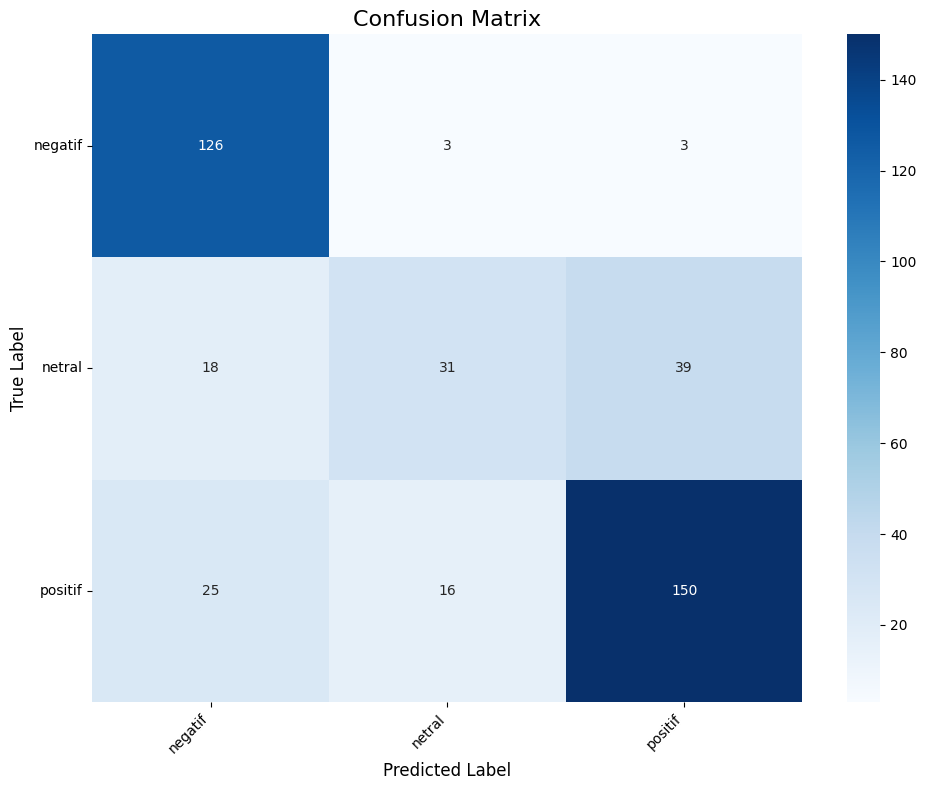


Classification Report:
             precision recall f1-score support
     negatif    0.7456 0.9545   0.8372   132.0
      netral    0.6200 0.3523   0.4493    88.0
     positif    0.7812 0.7853   0.7833   191.0
    accuracy    0.7470                   411.0
   macro avg    0.7156 0.6974   0.6899   411.0
weighted avg    0.7353 0.7470   0.7291   411.0

ROC AUC per kelas:
negatif: 0.9228
netral: 0.7586
positif: 0.8960


In [17]:
display_evaluation_results(evaluation_report, label_map)